In [42]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from src.data_loader import create_tiledataloader_split
from src.model.mae import MAEUNetPretrain
from src.model.unet import Mid_fusion_UNetRegression
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, Callback, BaseFinetuning
from torchsummary import summary

def get_device():
    """
    Automatically selects the best available device (GPU if available, otherwise CPU).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device


device = get_device()

Using MPS


### Load data tiles

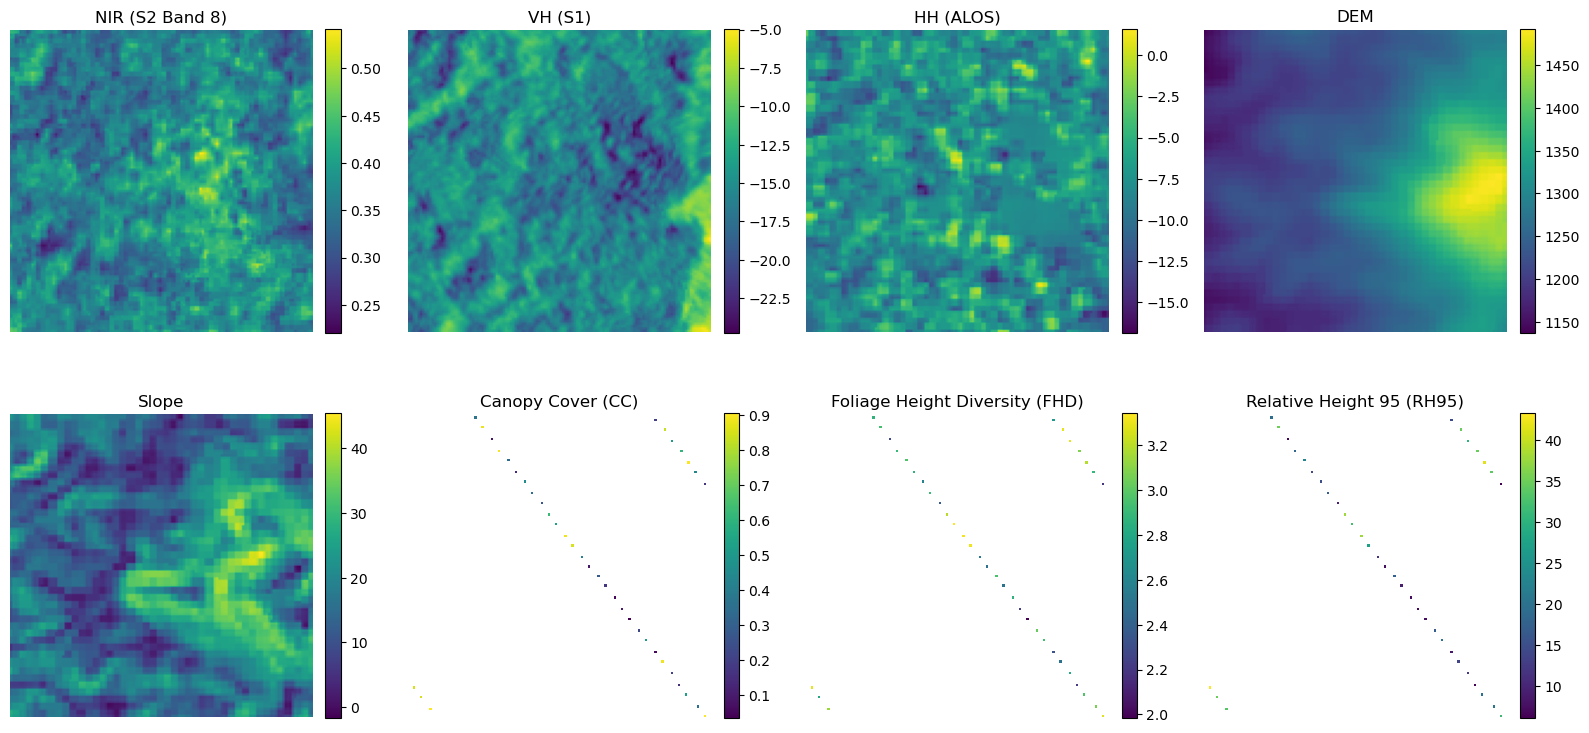

In [2]:
x = np.load("data/processed/X_tile_tile_115_5.npy")
y = np.load("data/processed/y_tile_tile_115_5.npy")

x_s2, x_s1, x_dem = x[0:20], x[20:26], x[26:]

images = [
    x_s2[6],  # NIR
    x_s1[1],  # VH
    10*np.log10(x_s1[4]**2)-83,  # HH to db
    x_dem[0], # DEM
    x_dem[1], # Slope
    y[0],     # CC
    y[1],     # FHD
    y[2]      # RH95
]

titles = [
    "NIR (S2 Band 8)",
    "VH (S1)",
    "HH (ALOS)",
    "DEM",
    "Slope",
    "Canopy Cover (CC)",
    "Foliage Height Diversity (FHD)",
    "Relative Height 95 (RH95)"
]

# Plot
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, axi in enumerate(ax.flat):

    im = axi.imshow(images[i], interpolation="nearest" if i >= 5 else None)
    plt.colorbar(im, ax=axi, fraction=0.046, pad=0.04)

    axi.set_title(titles[i])
    axi.axis("off")

plt.tight_layout()
plt.show()


In [3]:
files = glob("data/processed/y*.npy")
train_paths, val_paths = train_test_split(
    files, test_size=0.2, shuffle=True, random_state=1
)
val_paths, test_paths = train_test_split(
    val_paths, test_size=0.5, shuffle=True, random_state=1
)

In [37]:
scaling_file = "experiments/weights/scaler.pickle"
with open(scaling_file, "rb") as handle:
    means, stds, mean_y, std_y = pickle.load(handle)
# 
batch_size = 4
train_loader = create_tiledataloader_split(
    train_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=True,
)
val_loader = create_tiledataloader_split(
    val_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=False,
)
test_loader = create_tiledataloader_split(
    test_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=False,
)

for x_s2, x_s1, x_dem, y in test_loader:
    print(np.nanstd(x_s2.numpy(), axis=(0, 2, 3)))
    print(np.nanmean(y.numpy(), axis=(0, 2, 3)))
    break

[0.9289913  1.0170214  0.92443156 0.9618666  0.8984263  0.82675844
 0.7761748  0.8083782  0.7873316  0.7344803  1.0033636  1.0672414
 0.84556144 0.6651825  0.67002374 0.16698003 0.21225098 0.6641704
 0.6758766  0.50735265]
[ 0.03278802 -0.13969779 -0.10975066]


In [18]:
model = MAEUNetPretrain(
    in_channels=20,
    dimensions=2,
    out_channels_first_layer=16,
    conv_num_in_layer=[2, 2, 2, 2],
    kernel_size=5,
    normalization="Batch",
    downsampling_type="max",
    residual=True,
    padding_mode="zeros",
    activation="LeakyReLU",
    upsampling_type="conv",
    use_bias=True,
    use_sigmoid=False,
    lr=1e-3,
    lr_decay=0.1,
    weight_decay=1e-4,
    patch_size=128,
    mask_ratio=0.75,
    mask_channels=True,
    sensor_train="s2",
)
model = model.to(device)
summary(model, (20, 128, 128))

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [2, 16, 128, 128]         --
|    └─ModuleList: 2                          []                        --
|    |    └─EncodingBlock: 3-1                [-1, 16, 64, 64]          14,832
|    |    └─EncodingBlock: 3-2                [-1, 32, 32, 32]          39,136
|    |    └─EncodingBlock: 3-3                [-1, 64, 16, 16]          156,096
├─EncodingBlock: 1-2                          [-1, 128, 16, 16]         --
|    └─ConvolutionalBlock: 2-1                [-1, 128, 16, 16]         --
|    |    └─Sequential: 3-4                   [-1, 128, 16, 16]         8,320
|    └─Sequential: 2-2                        [-1, 128, 16, 16]         --
|    |    └─ConvolutionalBlock: 3-5           [-1, 128, 16, 16]         205,184
|    |    └─ConvolutionalBlock: 3-6           [-1, 128, 16, 16]         409,984
├─Decoder: 1-3                                [-1, 32, 128, 128]     

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [2, 16, 128, 128]         --
|    └─ModuleList: 2                          []                        --
|    |    └─EncodingBlock: 3-1                [-1, 16, 64, 64]          14,832
|    |    └─EncodingBlock: 3-2                [-1, 32, 32, 32]          39,136
|    |    └─EncodingBlock: 3-3                [-1, 64, 16, 16]          156,096
├─EncodingBlock: 1-2                          [-1, 128, 16, 16]         --
|    └─ConvolutionalBlock: 2-1                [-1, 128, 16, 16]         --
|    |    └─Sequential: 3-4                   [-1, 128, 16, 16]         8,320
|    └─Sequential: 2-2                        [-1, 128, 16, 16]         --
|    |    └─ConvolutionalBlock: 3-5           [-1, 128, 16, 16]         205,184
|    |    └─ConvolutionalBlock: 3-6           [-1, 128, 16, 16]         409,984
├─Decoder: 1-3                                [-1, 32, 128, 128]     

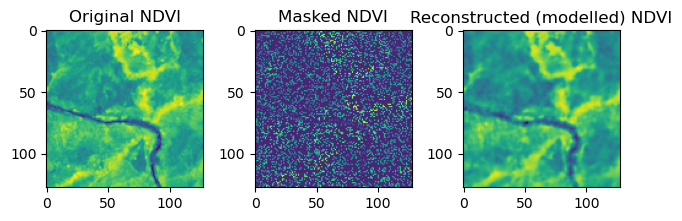

In [39]:
s2_checkpoint = torch.load("experiments/weights/biomass-unet-s2-pretrain-epoch=98-val_loss=0.05282.ckpt", map_location=torch.device(device))
pretrained_state_s2 = s2_checkpoint["state_dict"]
model.load_state_dict(pretrained_state_s2)

model.eval()
with torch.no_grad():
    x_rec, mask = model(x_s2)
    x_rec = x_rec.detach().numpy()
    x_rec = x_rec*stds[:, 0:20]+means[:, 0:20]

x_all = torch.cat((x_s2, x_s1, x_dem), axis=1)
x_all = x_all*stds+means

x_masked = x_all.clone().detach()
x_masked = x_masked[:, 0:20].masked_fill_(mask, 0)

fig, ax = plt.subplots(1, 3)
idx = 1
band = 12
ax[0].imshow(x_all[idx][band])
ax[1].imshow(x_masked[idx][band])
ax[2].imshow(x_rec[idx][band])

ax[0].set_title("Original NDVI")
ax[1].set_title("Masked NDVI")
ax[2].set_title("Reconstructed (modelled) NDVI")
plt.tight_layout()

In [48]:
unfreeze_epoch = 10
model_regressor = Mid_fusion_UNetRegression(
    in_channels_s2=20, in_channels_s1=6, in_channels_dem=2, 
        out_channels=3,
        lr=1e-3, 
        lr_decay=0.1, 
        total_iters=unfreeze_epoch,
        weight_decay=1e-4, 
        s2_weights=None, 
        s1_weights=None,
        dem_weights=None
)
path_multi = "experiments/weights/biomass-estimation-gedi-epoch=68-val_loss=1.56364.ckpt"
s2_checkpoint = torch.load(path_multi, map_location=torch.device(device))
pretrained_state_s2 = s2_checkpoint["state_dict"]
model_regressor.load_state_dict(pretrained_state_s2)

<All keys matched successfully>

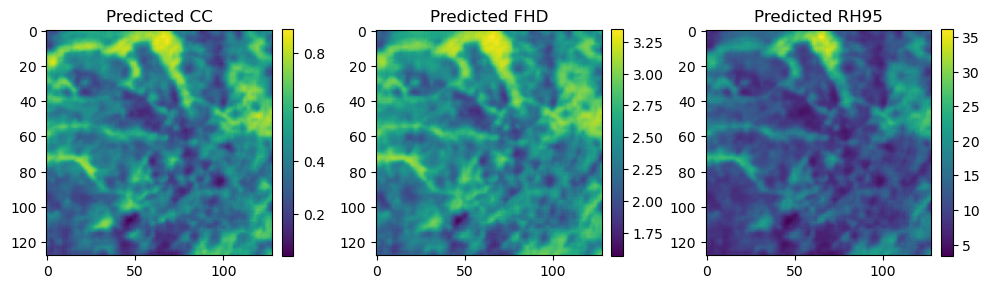

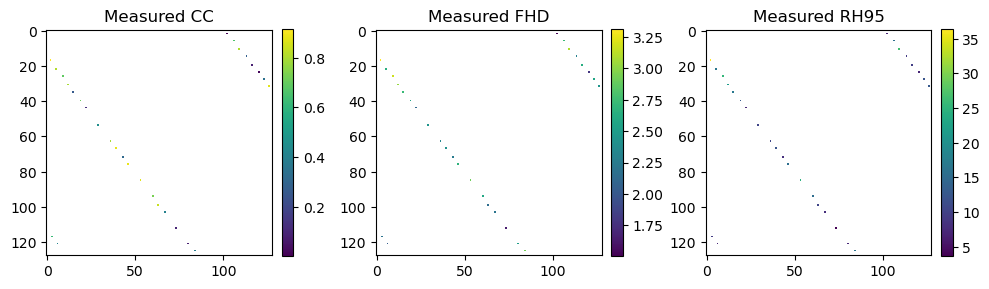

In [68]:
predicted = model_regressor(x_s2, x_s1, x_dem)
predicted = predicted.detach().numpy()*std_y + mean_y
idx = 2
labels = ["CC", "FHD", "RH95"]
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    ax = axes[i]
    im = ax.imshow(predicted[idx][i])
    ax.set_title("Predicted " + labels[i])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

measured = y.detach().numpy()*std_y + mean_y
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    ax = axes[i]
    im = ax.imshow(measured[idx][i], interpolation="nearest")
    ax.set_title("Measured " + labels[i])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()